# Diabetes Dataset with H2O.ai(2)

**By: Yashasvi Jariwala**

Dataset : Diabetes ("https://www.kaggle.com/mehdidag/pima-indians")

In [3]:
import h2o
from h2o.automl import H2OAutoML
import random, os, sys
from datetime import datetime
import pandas as pd
import logging
import csv
import optparse
import time
import json
from distutils.util import strtobool


/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [1]:
pwd

'/Users/yashasvijariwala'

In [2]:
cd Desktop

/Users/yashasvijariwala/Desktop


In [4]:
data_path=None
all_variables=None
test_path=None
target=None
nthreads=1 
min_mem_size=6 
run_time=333
classification=False
scale=False
max_models=9    
model_path=None
balance_y=False 
balance_threshold=0.2
name=None 
server_path=None  
analysis=0

In [5]:
# Functions

def alphabet(n):
  alpha='0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ'    
  str=''
  r=len(alpha)-1   
  while len(str)<n:
    i=random.randint(0,r)
    str+=alpha[i]   
  return str
  
  
def set_meta_data(run_id,analysis,target,run_time,classification,scale,model,balance,balance_threshold,name,nthreads,min_mem_size):
  m_data={}
  m_data['run_id'] =run_id
  m_data['start_time'] = time.time()
  m_data['target']=target
  m_data['max_models']=model
  m_data['run_time']=run_time
  m_data['scale']=scale
  m_data['classification']=classification
  m_data['scale']=False
  m_data['balance']=balance
  m_data['balance_threshold']=balance_threshold
  m_data['project'] =name
  m_data['end_time'] = time.time()
  m_data['execution_time'] = 0.0
  m_data['nthreads'] = nthreads
  m_data['min_mem_size'] = min_mem_size
  m_data['analysis'] = analysis
  return m_data


def dict_to_json(dct,n):
  j = json.dumps(dct, indent=4)
  f = open(n, 'w')
  print(j, file=f)
  f.close()
  
  
def stackedensemble(mod):
    coef_norm=None
    try:
      metalearner = h2o.get_model(mod.metalearner()['name'])
      coef_norm=metalearner.coef_norm()
    except:
      pass        
    return coef_norm

def stackedensemble_df(df):
    bm_algo={ 'GBM': None,'GLM': None,'DRF': None,'XRT': None,'Dee': None}
    for index, row in df.iterrows():
      if len(row['model_id'])>3:
        key=row['model_id'][0:3]
        if key in bm_algo:
          if bm_algo[key] is None:
                bm_algo[key]=row['model_id']
    bm=list(bm_algo.values()) 
    bm=list(filter(None.__ne__, bm))             
    return bm

def se_stats(modl):
    d={}
    d['algo']=modl.algo
    d['model_id']=modl.model_id   
    d['auc']=modl.auc()   
    d['roc']=modl.roc()
    d['mse']=modl.mse()   
    d['null_degrees_of_freedom']=modl.null_degrees_of_freedom()
    d['null_deviance']=modl.null_deviance()
    d['residual_degrees_of_freedom']=modl.residual_degrees_of_freedom()   
    d['residual_deviance']=modl.residual_deviance()
    d['rmse']=modl.rmse()
    return d

def get_model_by_algo(algo,models_dict):
    mod=None
    mod_id=None    
    for m in list(models_dict.keys()):
        if m[0:3]==algo:
            mod_id=m
            mod=h2o.get_model(m)      
    return mod,mod_id     
    
    
def gbm_stats(modl):
    d={}
    d['algo']=modl.algo
    d['model_id']=modl.model_id   
    d['varimp']=modl.varimp()  
    return d
    
    
def dl_stats(modl):
    d={}
    d['algo']=modl.algo
    d['model_id']=modl.model_id   
    d['varimp']=modl.varimp()  
    return d
    
    
def drf_stats(modl):
    d={}
    d['algo']=modl.algo
    d['model_id']=modl.model_id   
    d['varimp']=modl.varimp()  
    d['roc']=modl.roc()      
    return d
    
def xrt_stats(modl):
    d={}
    d['algo']=modl.algo
    d['model_id']=modl.model_id   
    d['varimp']=modl.varimp()  
    d['roc']=modl.roc()      
    return d
    
    
def glm_stats(modl):
    d={}
    d['algo']=modl.algo
    d['model_id']=modl.model_id   
    d['coef']=modl.coef()  
    d['coef_norm']=modl.coef_norm()      
    return d
    
def model_performance_stats(perf):
    d={}
    try:    
      d['mse']=perf.mse()
    except:
      pass      
    try:    
      d['rmse']=perf.rmse() 
    except:
      pass      
    try:    
      d['null_degrees_of_freedom']=perf.null_degrees_of_freedom()
    except:
      pass      
    try:    
      d['residual_degrees_of_freedom']=perf.residual_degrees_of_freedom()
    except:
      pass      
    try:    
      d['residual_deviance']=perf.residual_deviance() 
    except:
      pass      
    try:    
      d['null_deviance']=perf.null_deviance() 
    except:
      pass      
    try:    
      d['aic']=perf.aic() 
    except:
      pass      
    try:
      d['logloss']=perf.logloss() 
    except:
      pass    
    try:
      d['auc']=perf.auc()
    except:
      pass  
    try:
      d['gini']=perf.gini()
    except:
      pass    
    return d
    
def impute_missing_values(df, x, scal=False):
    # determine column types
    ints, reals, enums = [], [], []
    for key, val in df.types.items():
        if key in x:
            if val == 'enum':
                enums.append(key)
            elif val == 'int':
                ints.append(key)            
            else: 
                reals.append(key)    
    _ = df[reals].impute(method='mean')
    _ = df[ints].impute(method='median')
    if scal:
        df[reals] = df[reals].scale()
        df[ints] = df[ints].scale()    
    return


def get_independent_variables(df, targ):
    C = [name for name in df.columns if name != targ]
    # determine column types
    ints, reals, enums = [], [], []
    for key, val in df.types.items():
        if key in C:
            if val == 'enum':
                enums.append(key)
            elif val == 'int':
                ints.append(key)            
            else: 
                reals.append(key)    
    x=ints+enums+reals
    return x
    
def get_all_variables_csv(i):
    ivd={}
    try:
      iv = pd.read_csv(i,header=None)
    except:
      sys.exit(1)    
    col=iv.values.tolist()[0]
    dt=iv.values.tolist()[1]
    i=0
    for c in col:
      ivd[c.strip()]=dt[i].strip()
      i+=1        
    return ivd
    
    

def check_all_variables(df,dct,y=None):     
    targ=list(dct.keys())     
    for key, val in df.types.items():
        if key in targ:
          if dct[key] not in ['real','int','enum']:                      
            targ.remove(key)  
    for key, val in df.types.items():
        if key in targ:            
          if dct[key] != val:
            print('convert ',key,' ',dct[key],' ',val)
            if dct[key]=='enum':
                try:
                  df[key] = df[key].asfactor() 
                except:
                  targ.remove(key)                 
            if dct[key]=='int': 
                try:                
                  df[key] = df[key].asnumeric() 
                except:
                  targ.remove(key)                  
            if dct[key]=='real':
                try:                
                  df[key] = df[key].asnumeric()  
                except:
                  targ.remove(key)                  
    if y is None:
      y=df.columns[-1] 
    if y in targ:
      targ.remove(y)
    else:
      y=targ.pop()            
    return targ    
    
def predictions(mod,data,run_id):
    test = h2o.import_file(data)
    mod_perf=mod_best.model_performance(test)
              
    stats_test={}
    stats_test=model_performance_stats(mod_perf)

    n=run_id+'_test_stats.json'
    dict_to_json(stats_test,n) 

    try:    
      cf=mod_perf.confusion_matrix(metrics=["f1","f2","f0point5","accuracy","precision","recall","specificity","absolute_mcc","min_per_class_accuracy","mean_per_class_accuracy"])
      cf_df=cf[0].table.as_data_frame()
      cf_df.to_csv(run_id+'_test_confusion_matrix.csv')
    except:
      pass

    predictions = mod_best.predict(test)
    predictions_df=test.cbind(predictions).as_data_frame() 
    predictions_df.to_csv(run_id+'_predictions.csv')
    return

def predictions_test(mod,test,run_id):
    mod_perf=mod_best.model_performance(test)          
    stats_test={}
    stats_test=model_performance_stats(mod_perf)
    n=run_id+'_test_stats.json'
    dict_to_json(stats_test,n) 
    try:
      cf=mod_perf.confusion_matrix(metrics=["f1","f2","f0point5","accuracy","precision","recall","specificity","absolute_mcc","min_per_class_accuracy","mean_per_class_accuracy"])
      cf_df=cf[0].table.as_data_frame()
      cf_df.to_csv(run_id+'_test_confusion_matrix.csv')
    except:
      pass
    predictions = mod_best.predict(test)    
    predictions_df=test.cbind(predictions).as_data_frame() 
    predictions_df.to_csv(run_id+'_predictions.csv')
    return predictions

def check_X(x,df):
    for name in x:
        if name not in df.columns:
          x.remove(name)  
    return x    
    
    
def get_stacked_ensemble(lst):
    se=None
    for model in model_set:
      if 'BestOfFamily' in model:
        se=model
    if se is None:     
      for model in model_set:
        if 'AllModels'in model:
          se=model           
    return se       
    
def get_variables_types(df):
    d={}
    for key, val in df.types.items():
        d[key]=val           
    return d    
    
#  End Functions

In [6]:
data_path='Diabetes.csv'

In [7]:
data_path = os.path.join(os.path.abspath(os.curdir),data_path)

In [8]:
all_variables=None

In [9]:
run_id=alphabet(9)
# run_id to std out
print (run_id)

aJOlAQdcF


In [10]:
server_path=os.path.abspath(os.curdir)
os.chdir(server_path) 
run_dir = os.path.join(server_path,run_id)
os.mkdir(run_dir)
os.chdir(run_dir)

In [11]:
# 65535 Highest port no
port_no=random.randint(5555,55555)
h2o.init(strict_version_check=False,min_mem_size_GB=min_mem_size,port=port_no)

Checking whether there is an H2O instance running at http://localhost:10091..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_161"; Java(TM) SE Runtime Environment (build 1.8.0_161-b12); Java HotSpot(TM) 64-Bit Server VM (build 25.161-b12, mixed mode)
  Starting server from /anaconda3/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/1p/9ykp1qd57gd26nrw11zjq09c0000gn/T/tmpjpidovyf
  JVM stdout: /var/folders/1p/9ykp1qd57gd26nrw11zjq09c0000gn/T/tmpjpidovyf/h2o_yashasvijariwala_started_from_python.out
  JVM stderr: /var/folders/1p/9ykp1qd57gd26nrw11zjq09c0000gn/T/tmpjpidovyf/h2o_yashasvijariwala_started_from_python.err
  Server is running at http://127.0.0.1:10091
Connecting to H2O server at http://127.0.0.1:10091... successful.


H2O cluster uptime:,01 secs
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.20.0.3
H2O cluster version age:,3 months and 21 days !!!
H2O cluster name:,H2O_from_python_yashasvijariwala_21yqk4
H2O cluster total nodes:,1
H2O cluster free memory:,5.750 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"accepting new members, healthy"


In [12]:
# meta data
meta_data = set_meta_data(run_id,analysis,target,run_time,classification,scale,max_models,balance_y,balance_threshold,name,nthreads,min_mem_size)
print(meta_data)

{'run_id': 'aJOlAQdcF', 'start_time': 1541098161.5768268, 'target': None, 'max_models': 9, 'run_time': 333, 'scale': False, 'classification': False, 'balance': False, 'balance_threshold': 0.2, 'project': None, 'end_time': 1541098161.576829, 'execution_time': 0.0, 'nthreads': 1, 'min_mem_size': 6, 'analysis': 0}


In [13]:
print(data_path)


/Users/yashasvijariwala/Desktop/Diabetes.csv


In [14]:
df = h2o.import_file(data_path)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [17]:
df.head()

C1,C2,C3,C4,C5,C6,C7,C8,C9
6,148,72,35,0,33.6,0.627,50,1
1,85,66,29,0,26.6,0.351,31,0
8,183,64,0,0,23.3,0.672,32,1
1,89,66,23,94,28.1,0.167,21,0
0,137,40,35,168,43.1,2.288,33,1
5,116,74,0,0,25.6,0.201,30,0
3,78,50,32,88,31,0.248,26,1
10,115,0,0,0,35.3,0.134,29,0
2,197,70,45,543,30.5,0.158,53,1
8,125,96,0,0,0,0.232,54,1


In [18]:
df.describe()

Rows:768
Cols:9




,C1,C2,C3,C4,C5,C6,C7,C8,C9
type,int,int,int,int,int,real,real,int,int
mins,0.0,0.0,0.0,0.0,0.0,0.0,0.078,21.0,0.0
mean,3.845052083333336,120.89453125,69.10546874999994,20.536458333333357,79.79947916666666,31.99257812500003,0.4718763020833334,33.240885416666615,0.3489583333333333
maxs,17.0,199.0,122.0,99.0,846.0,67.1,2.42,81.0,1.0
sigma,3.36957806269887,31.972618195136224,19.355807170644777,15.952217567727642,115.24400235133803,7.884160320375441,0.331328595012775,11.760231540678689,0.47695137724279896
zeros,111,5,35,227,374,11,0,0,500
missing,0,0,0,0,0,0,0,0,0
0,6.0,148.0,72.0,35.0,0.0,33.6,0.627,50.0,1.0
1,1.0,85.0,66.0,29.0,0.0,26.6,0.351,31.0,0.0
2,8.0,183.0,64.0,0.0,0.0,23.3,0.672,32.0,1.0


In [19]:
# dependent variable
# assign target and inputs for classification or regression
if target==None:
  target=df.columns[-1]   
y = target

In [20]:
print(y)

C9


In [21]:
print(all_variables)

None


In [22]:
if all_variables is not None:
  ivd=get_all_variables_csv(all_variables)
  print(ivd)    
  X=check_all_variables(df,ivd,y)
  print(X)

In [23]:
df.describe()

Rows:768
Cols:9




,C1,C2,C3,C4,C5,C6,C7,C8,C9
type,int,int,int,int,int,real,real,int,int
mins,0.0,0.0,0.0,0.0,0.0,0.0,0.078,21.0,0.0
mean,3.845052083333336,120.89453125,69.10546874999994,20.536458333333357,79.79947916666666,31.99257812500003,0.4718763020833334,33.240885416666615,0.3489583333333333
maxs,17.0,199.0,122.0,99.0,846.0,67.1,2.42,81.0,1.0
sigma,3.36957806269887,31.972618195136224,19.355807170644777,15.952217567727642,115.24400235133803,7.884160320375441,0.331328595012775,11.760231540678689,0.47695137724279896
zeros,111,5,35,227,374,11,0,0,500
missing,0,0,0,0,0,0,0,0,0
0,6.0,148.0,72.0,35.0,0.0,33.6,0.627,50.0,1.0
1,1.0,85.0,66.0,29.0,0.0,26.6,0.351,31.0,0.0
2,8.0,183.0,64.0,0.0,0.0,23.3,0.672,32.0,1.0


In [24]:

# independent variables

X = []  
if all_variables is None:
  X=get_independent_variables(df, target)  
else: 
  ivd=get_all_variables_csv(all_variables)    
  X=check_all_variables(df, ivd)


X=check_X(X,df)


# Add independent variables

meta_data['X']=X  


# impute missing values

_=impute_missing_values(df,X, scale)

In [25]:
if analysis == 3:
  classification=False
elif analysis == 2:
  classification=True
elif analysis == 1:
  classification=True

In [26]:
print(classification)

False


In [27]:
# Force target to be factors
# Only 'int' or 'string' are allowed for asfactor(), got Target (Total orders):real 

if classification:
    df[y] = df[y].asfactor()

In [28]:
def check_y(y,df):
  ok=False
  C = [name for name in df.columns if name == y]
  for key, val in df.types.items():
    if key in C:
      if val in ['real','int','enum']:        
        ok=True         
  return ok, val

In [29]:
ok,val=check_y(y,df)

In [30]:
print(val)

int


In [31]:
print(ok)

True


In [32]:
if val=='int':
    print((df[y].levels()))

[]


In [33]:
df.describe()

Rows:768
Cols:9




,C1,C2,C3,C4,C5,C6,C7,C8,C9
type,int,int,int,int,int,real,real,int,int
mins,0.0,0.0,0.0,0.0,0.0,0.0,0.078,21.0,0.0
mean,3.845052083333336,120.89453125,69.10546874999994,20.536458333333357,79.79947916666666,31.99257812500003,0.4718763020833334,33.240885416666615,0.3489583333333333
maxs,17.0,199.0,122.0,99.0,846.0,67.1,2.42,81.0,1.0
sigma,3.36957806269887,31.972618195136224,19.355807170644777,15.952217567727642,115.24400235133803,7.884160320375441,0.331328595012775,11.760231540678689,0.47695137724279896
zeros,111,5,35,227,374,11,0,0,500
missing,0,0,0,0,0,0,0,0,0
0,6.0,148.0,72.0,35.0,0.0,33.6,0.627,50.0,1.0
1,1.0,85.0,66.0,29.0,0.0,26.6,0.351,31.0,0.0
2,8.0,183.0,64.0,0.0,0.0,23.3,0.672,32.0,1.0


In [34]:
allV=get_variables_types(df)
allV

{'C1': 'int',
 'C2': 'int',
 'C3': 'int',
 'C4': 'int',
 'C5': 'int',
 'C6': 'real',
 'C7': 'real',
 'C8': 'int',
 'C9': 'int'}

In [35]:
meta_data['variables']=allV

In [36]:
# split into training and test for showing how to predict
train, test = df.split_frame([0.9])

In [37]:
# Set up AutoML

aml = H2OAutoML(max_runtime_secs=run_time,project_name = name)

In [38]:
model_start_time = time.time()

In [39]:
aml.train(x=X,y=y,training_frame=train)

AutoML progress: |████████████████████████████████████████████████████████| 100%


/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [40]:
meta_data['model_execution_time'] = time.time() - model_start_time

In [41]:
# get leaderboard
aml_leaderboard_df=aml.leaderboard.as_data_frame()

In [42]:
aml_leaderboard_df

,model_id,mean_residual_deviance,rmse,mse,mae,rmsle
0,StackedEnsemble_BestOfFamily_0_AutoML_20181101...,0.153529,0.391828,0.153529,0.316304,0.275736
1,StackedEnsemble_AllModels_0_AutoML_20181101_14...,0.154947,0.393633,0.154947,0.316255,0.276510
2,DeepLearning_grid_0_AutoML_20181101_145038_mod...,0.159748,0.399685,0.159748,0.322417,0.282444
3,GLM_grid_0_AutoML_20181101_145038_model_0,0.160484,0.400605,0.160484,0.335905,0.287007
4,GBM_grid_0_AutoML_20181101_145038_model_3,0.160563,0.400703,0.160563,0.311417,0.281585
5,DeepLearning_0_AutoML_20181101_145038,0.161638,0.402042,0.161638,0.323375,0.284169
6,GBM_grid_0_AutoML_20181101_145038_model_4,0.162180,0.402716,0.162180,0.335890,0.282789
7,GBM_grid_0_AutoML_20181101_145038_model_7,0.162960,0.403683,0.162960,0.306709,0.283314
8,GBM_grid_0_AutoML_20181101_145038_model_1,0.164705,0.405839,0.164705,0.312108,0.285583
9,XRT_0_AutoML_20181101_145038,0.168611,0.410622,0.168611,0.311529,0.288051


In [43]:
# STart best model as first model

model_set=aml_leaderboard_df['model_id']
mod_best=h2o.get_model(model_set[0])

In [44]:
mod_best._id

'StackedEnsemble_BestOfFamily_0_AutoML_20181101_145038'

In [45]:
# Get stacked ensemble  
se=get_stacked_ensemble(model_set)

In [46]:
print(se)

StackedEnsemble_BestOfFamily_0_AutoML_20181101_145038


In [47]:
if se is not None:
  mod_best=h2o.get_model(se)

In [48]:
mod_best._id

'StackedEnsemble_BestOfFamily_0_AutoML_20181101_145038'

In [49]:
mod_best._get_metrics


<function h2o.model.model_base.ModelBase._get_metrics(o, train, valid, xval)>

In [50]:
type(mod_best)

h2o.estimators.stackedensemble.H2OStackedEnsembleEstimator

In [51]:
mods=mod_best.coef_norm
print(mods)

Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_BestOfFamily_0_AutoML_20181101_145038
No model summary for this model


ModelMetricsRegressionGLM: stackedensemble
** Reported on train data. **

MSE: 0.08185285538316601
RMSE: 0.2860993802565221
MAE: 0.23011614204186676
RMSLE: 0.20290996236018552
R^2: 0.6376317561391001
Mean Residual Deviance: 0.08185285538316601
Null degrees of freedom: 556
Residual degrees of freedom: 552
Null deviance: 125.81687612208346
Residual deviance: 45.59204044842347
AIC: 198.6200517416415

ModelMetricsRegressionGLM: stackedensemble
** Reported on validation data. **

MSE: 0.1789382900263803
RMSE: 0.4230109809761211
MAE: 0.34421681279698657
RMSLE: 0.2892336019242286
R^2: 0.26476244831382856
Mean Residual Deviance: 0.1789382900263803
Null degrees of freedom: 128
Residual degrees of freedom: 124
Null deviance: 32.09986172397003
Residual deviance: 23.083039413403057
AIC: 156.11399931306244

ModelMetricsRegressionGLM: stack

In [52]:
bm=stackedensemble_df(aml_leaderboard_df)


In [53]:
bm

['GBM_grid_0_AutoML_20181101_145038_model_3',
 'GLM_grid_0_AutoML_20181101_145038_model_0',
 'DRF_0_AutoML_20181101_145038',
 'XRT_0_AutoML_20181101_145038',
 'DeepLearning_grid_0_AutoML_20181101_145038_model_1']

In [54]:
aml_leaderboard_df

,model_id,mean_residual_deviance,rmse,mse,mae,rmsle
0,StackedEnsemble_BestOfFamily_0_AutoML_20181101...,0.153529,0.391828,0.153529,0.316304,0.275736
1,StackedEnsemble_AllModels_0_AutoML_20181101_14...,0.154947,0.393633,0.154947,0.316255,0.276510
2,DeepLearning_grid_0_AutoML_20181101_145038_mod...,0.159748,0.399685,0.159748,0.322417,0.282444
3,GLM_grid_0_AutoML_20181101_145038_model_0,0.160484,0.400605,0.160484,0.335905,0.287007
4,GBM_grid_0_AutoML_20181101_145038_model_3,0.160563,0.400703,0.160563,0.311417,0.281585
5,DeepLearning_0_AutoML_20181101_145038,0.161638,0.402042,0.161638,0.323375,0.284169
6,GBM_grid_0_AutoML_20181101_145038_model_4,0.162180,0.402716,0.162180,0.335890,0.282789
7,GBM_grid_0_AutoML_20181101_145038_model_7,0.162960,0.403683,0.162960,0.306709,0.283314
8,GBM_grid_0_AutoML_20181101_145038_model_1,0.164705,0.405839,0.164705,0.312108,0.285583
9,XRT_0_AutoML_20181101_145038,0.168611,0.410622,0.168611,0.311529,0.288051


In [55]:
#  Get best_models and coef_norm()
best_models={}
best_models=stackedensemble(mod_best)
bm=[]
if best_models is not None: 
  if 'Intercept' in best_models.keys():
    del best_models['Intercept']
  bm=list(best_models.keys())
else:
  best_models={}
  bm=stackedensemble_df(aml_leaderboard_df)   
  for b in bm:   
    best_models[b]=None

if mod_best.model_id not in bm:
    bm.append(mod_best.model_id)

In [56]:
bm


['DeepLearning_grid_0_AutoML_20181101_145038_model_1',
 'GLM_grid_0_AutoML_20181101_145038_model_0',
 'GBM_grid_0_AutoML_20181101_145038_model_3',
 'XRT_0_AutoML_20181101_145038',
 'DRF_0_AutoML_20181101_145038',
 'StackedEnsemble_BestOfFamily_0_AutoML_20181101_145038']

In [57]:
# Best of Family leaderboard

aml_leaderboard_df=aml_leaderboard_df.loc[aml_leaderboard_df['model_id'].isin(bm)]

In [58]:
aml_leaderboard_df


,model_id,mean_residual_deviance,rmse,mse,mae,rmsle
0,StackedEnsemble_BestOfFamily_0_AutoML_20181101...,0.153529,0.391828,0.153529,0.316304,0.275736
2,DeepLearning_grid_0_AutoML_20181101_145038_mod...,0.159748,0.399685,0.159748,0.322417,0.282444
3,GLM_grid_0_AutoML_20181101_145038_model_0,0.160484,0.400605,0.160484,0.335905,0.287007
4,GBM_grid_0_AutoML_20181101_145038_model_3,0.160563,0.400703,0.160563,0.311417,0.281585
9,XRT_0_AutoML_20181101_145038,0.168611,0.410622,0.168611,0.311529,0.288051
13,DRF_0_AutoML_20181101_145038,0.187791,0.433349,0.187791,0.335791,0.304753


In [59]:
# save leaderboard
leaderboard_stats=run_id+'_leaderboard.csv'
aml_leaderboard_df.to_csv(leaderboard_stats)

In [60]:
top=aml_leaderboard_df.iloc[0]['model_id']
print(top)

StackedEnsemble_BestOfFamily_0_AutoML_20181101_145038


# New Notebook

In [61]:
import h2o
from h2o.automl import H2OAutoML

In [62]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,3 hours 17 mins
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.20.0.3
H2O cluster version age:,3 months and 21 days !!!
H2O cluster name:,H2O_from_python_yashasvijariwala_1ja6gp
H2O cluster total nodes:,1
H2O cluster free memory:,1.612 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"locked, healthy"


In [63]:
pwd

'/Users/yashasvijariwala/Desktop/aJOlAQdcF'

In [64]:
cd ..

/Users/yashasvijariwala/Desktop


In [65]:
data = h2o.import_file("Diabetes.csv")

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [68]:
# Identify predictors and response
x = train.columns
y = "C9"
x.remove(y)

In [69]:
train,test,valid = data.split_frame(ratios=[.8, .10])

In [70]:
# Identify predictors and response
train[y] = train[y].asfactor()
test[y] = test[y].asfactor()

In [71]:
# Run AutoML for 20 base models (limited to 1 hour max runtime by default)
aml = H2OAutoML(max_models=20, seed=1)
aml.train(x=x, y=y, training_frame=train)

AutoML progress: |████████████████████████████████████████████████████████| 100%


In [72]:
# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

model_id,auc,logloss,mean_per_class_error,rmse,mse
GLM_grid_0_AutoML_20181101_145939_model_0,0.84703,0.470244,0.22648,0.387881,0.150452
StackedEnsemble_BestOfFamily_0_AutoML_20181101_145939,0.844912,0.469063,0.231185,0.389937,0.152051
DeepLearning_grid_0_AutoML_20181101_145939_model_6,0.844516,0.514347,0.229247,0.399214,0.159372
StackedEnsemble_AllModels_0_AutoML_20181101_145939,0.841009,0.473155,0.231032,0.39202,0.15368
DeepLearning_grid_0_AutoML_20181101_145939_model_1,0.839414,0.495792,0.221244,0.396604,0.157295
DeepLearning_grid_0_AutoML_20181101_145939_model_4,0.839342,0.513882,0.237161,0.403392,0.162725
DeepLearning_grid_0_AutoML_20181101_145939_model_0,0.838351,0.525293,0.232014,0.404493,0.163614
GBM_grid_0_AutoML_20181101_145939_model_4,0.827904,0.487679,0.240856,0.40232,0.161861
DeepLearning_0_AutoML_20181101_145939,0.819955,0.517503,0.24493,0.410451,0.16847
DeepLearning_grid_0_AutoML_20181101_145939_model_2,0.819757,0.602078,0.26621,0.425356,0.180928


In [73]:
# The leader model is stored here
aml.leader

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_0_AutoML_20181101_145939_model_0


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.14568572132508611
RMSE: 0.3816879894954596
LogLoss: 0.4555082024621318
Null degrees of freedom: 491
Residual degrees of freedom: 483
Null deviance: 640.4842415170043
Residual deviance: 448.2200712227378
AIC: 466.2200712227378
AUC: 0.8567823343848581
Gini: 0.7135646687697161
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3279216917080738: 


,0,1,Error,Rate
0,242.0,75.0,0.2366,(75.0/317.0)
1,33.0,142.0,0.1886,(33.0/175.0)
Total,275.0,217.0,0.2195,(108.0/492.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.3279217,0.7244898,187.0
max f2,0.1816565,0.8142999,259.0
max f0point5,0.6144803,0.7303371,97.0
max accuracy,0.4394757,0.7967480,150.0
max precision,0.9945196,1.0,0.0
max recall,0.0167282,1.0,392.0
max specificity,0.9945196,1.0,0.0
max absolute_mcc,0.4186584,0.5589027,159.0
max min_per_class_accuracy,0.3479019,0.7760252,180.0
max mean_per_class_accuracy,0.3279217,0.7874178,187.0


Gains/Lift Table: Avg response rate: 35.57 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0101626,0.9540460,2.2491429,2.2491429,0.8,0.8,0.0228571,0.0228571,124.9142857,124.9142857
,2,0.0203252,0.9391255,2.2491429,2.2491429,0.8,0.8,0.0228571,0.0457143,124.9142857,124.9142857
,3,0.0304878,0.9223396,2.2491429,2.2491429,0.8,0.8,0.0228571,0.0685714,124.9142857,124.9142857
,4,0.0406504,0.8876297,2.8114286,2.3897143,1.0,0.85,0.0285714,0.0971429,181.1428571,138.9714286
,5,0.0508130,0.8689847,2.8114286,2.4740571,1.0,0.88,0.0285714,0.1257143,181.1428571,147.4057143
,6,0.1016260,0.7951909,2.3616000,2.4178286,0.84,0.86,0.12,0.2457143,136.1600000,141.7828571
,7,0.1504065,0.7109585,2.3428571,2.3935135,0.8333333,0.8513514,0.1142857,0.36,134.2857143,139.3513514
,8,0.2012195,0.6539802,2.0242286,2.3002597,0.72,0.8181818,0.1028571,0.4628571,102.4228571,130.0259740
,9,0.3008130,0.4965234,1.6065306,2.0705792,0.5714286,0.7364865,0.16,0.6228571,60.6530612,107.0579151
,10,0.4004065,0.3738785,1.3196501,1.8837999,0.4693878,0.6700508,0.1314286,0.7542857,31.9650146,88.3799855




ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.13657233722605672
RMSE: 0.36955694720307547
LogLoss: 0.4282841743123544
Null degrees of freedom: 117
Residual degrees of freedom: 109
Null deviance: 148.89295925363277
Residual deviance: 101.07506513771564
AIC: 119.07506513771564
AUC: 0.8621710526315789
Gini: 0.7243421052631578
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5574961019206314: 


,0,1,Error,Rate
0,77.0,3.0,0.0375,(3.0/80.0)
1,15.0,23.0,0.3947,(15.0/38.0)
Total,92.0,26.0,0.1525,(18.0/118.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.5574961,0.71875,25.0
max f2,0.1415379,0.7949791,86.0
max f0point5,0.5574961,0.8098592,25.0
max accuracy,0.5574961,0.8474576,25.0
max precision,0.9623850,1.0,0.0
max recall,0.1415379,1.0,86.0
max specificity,0.9623850,1.0,0.0
max absolute_mcc,0.5574961,0.6400640,25.0
max min_per_class_accuracy,0.3404152,0.7631579,43.0
max mean_per_class_accuracy,0.3404152,0.7878289,43.0


Gains/Lift Table: Avg response rate: 32.20 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0169492,0.8741271,3.1052632,3.1052632,1.0,1.0,0.0526316,0.0526316,210.5263158,210.5263158
,2,0.0254237,0.8554084,3.1052632,3.1052632,1.0,1.0,0.0263158,0.0789474,210.5263158,210.5263158
,3,0.0338983,0.8164409,0.0,2.3289474,0.0,0.75,0.0,0.0789474,-100.0,132.8947368
,4,0.0423729,0.8004058,3.1052632,2.4842105,1.0,0.8,0.0263158,0.1052632,210.5263158,148.4210526
,5,0.0508475,0.7901239,3.1052632,2.5877193,1.0,0.8333333,0.0263158,0.1315789,210.5263158,158.7719298
,6,0.1016949,0.7294739,2.5877193,2.5877193,0.8333333,0.8333333,0.1315789,0.2631579,158.7719298,158.7719298
,7,0.1525424,0.6733203,3.1052632,2.7602339,1.0,0.8888889,0.1578947,0.4210526,210.5263158,176.0233918
,8,0.2033898,0.5804844,2.5877193,2.7171053,0.8333333,0.875,0.1315789,0.5526316,158.7719298,171.7105263
,9,0.3050847,0.3988897,0.7763158,2.0701754,0.25,0.6666667,0.0789474,0.6315789,-22.3684211,107.0175439
,10,0.3983051,0.3316978,1.4114833,1.9160134,0.4545455,0.6170213,0.1315789,0.7631579,41.1483254,91.6013438




ModelMetricsBinomialGLM: glm
** Reported on cross-validation data. **

MSE: 0.1504518549413431
RMSE: 0.38788123819197945
LogLoss: 0.47024369627192864
Null degrees of freedom: 491
Residual degrees of freedom: 483
Null deviance: 642.0800549683404
Residual deviance: 462.71979713157776
AIC: 480.71979713157776
AUC: 0.8470301937809824
Gini: 0.6940603875619649
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3228515658341001: 


,0,1,Error,Rate
0,235.0,82.0,0.2587,(82.0/317.0)
1,34.0,141.0,0.1943,(34.0/175.0)
Total,269.0,223.0,0.2358,(116.0/492.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.3228516,0.7085427,199.0
max f2,0.1773042,0.8144126,273.0
max f0point5,0.5692508,0.7196402,109.0
max accuracy,0.5692508,0.7845528,109.0
max precision,0.9920000,1.0,0.0
max recall,0.0195380,1.0,392.0
max specificity,0.9920000,1.0,0.0
max absolute_mcc,0.3228516,0.5260639,199.0
max min_per_class_accuracy,0.3438587,0.7657143,188.0
max mean_per_class_accuracy,0.3228516,0.7735196,199.0


Gains/Lift Table: Avg response rate: 35.57 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0101626,0.9558667,1.6868571,1.6868571,0.6,0.6,0.0171429,0.0171429,68.6857143,68.6857143
,2,0.0203252,0.9293748,2.2491429,1.9680000,0.8,0.7,0.0228571,0.04,124.9142857,96.8000000
,3,0.0304878,0.9032699,2.8114286,2.2491429,1.0,0.8,0.0285714,0.0685714,181.1428571,124.9142857
,4,0.0406504,0.8875101,2.8114286,2.3897143,1.0,0.85,0.0285714,0.0971429,181.1428571,138.9714286
,5,0.0508130,0.8728894,2.8114286,2.4740571,1.0,0.88,0.0285714,0.1257143,181.1428571,147.4057143
,6,0.1016260,0.7724962,2.3616000,2.4178286,0.84,0.86,0.12,0.2457143,136.1600000,141.7828571
,7,0.1504065,0.7230551,2.2257143,2.3555212,0.7916667,0.8378378,0.1085714,0.3542857,122.5714286,135.5521236
,8,0.2012195,0.6506147,2.0242286,2.2718615,0.72,0.8080808,0.1028571,0.4571429,102.4228571,127.1861472
,9,0.3008130,0.4891502,1.5491545,2.0325869,0.5510204,0.7229730,0.1542857,0.6114286,54.9154519,103.2586873
,10,0.4004065,0.3720651,1.3196501,1.8552574,0.4693878,0.6598985,0.1314286,0.7428571,31.9650146,85.5257433



Cross-Validation Metrics Summary: 


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
accuracy,0.7884560,0.0272671,0.8181818,0.8383839,0.7959183,0.7551020,0.7346939
auc,0.8450223,0.0235041,0.8882353,0.8553792,0.8685345,0.8028674,0.8100949
err,0.211544,0.0272671,0.1818182,0.1616162,0.2040816,0.2448980,0.2653061
err_count,20.8,2.6229753,18.0,16.0,20.0,24.0,26.0
f0point5,0.6928377,0.0504056,0.7079646,0.7777778,0.7451923,0.6590909,0.5741627
---,---,---,---,---,---,---,---
r2,0.3392086,0.0466591,0.3895709,0.4054222,0.3809836,0.2431896,0.2768767
recall,0.8254192,0.0431402,0.9411765,0.7777778,0.775,0.8055556,0.8275862
residual_deviance,91.082596,5.3341837,82.57715,90.400215,87.503204,105.12825,89.80417
rmse,0.3872337,0.0125068,0.371004,0.3709289,0.3866954,0.4193866,0.3881536



See the whole table with table.as_data_frame()
Scoring History: 


,timestamp,duration,iteration,lambda,predictors,deviance_train,deviance_test,deviance_xval,deviance_se
,2018-11-01 14:59:42,0.000 sec,2,.23E2,9,1.2917542,1.2538779,1.2971763,0.0209941
,2018-11-01 14:59:42,0.001 sec,4,.14E2,9,1.2858790,1.2492265,1.2925252,0.0207909
,2018-11-01 14:59:42,0.002 sec,6,.9E1,9,1.2767932,1.2420123,1.2852809,0.0204828
,2018-11-01 14:59:42,0.003 sec,8,.56E1,9,1.2630714,1.2310689,1.2742034,0.0200282
,2018-11-01 14:59:42,0.005 sec,10,.35E1,9,1.2430485,1.2149778,1.2577665,0.0193961
---,---,---,---,---,---,---,---,---,---
,2018-11-01 14:59:42,0.025 sec,34,.11E-1,9,0.9125217,0.8620558,0.9408561,0.0428494
,2018-11-01 14:59:42,0.027 sec,36,.71E-2,9,0.9110164,0.8565683,0.9407237,0.0457554
,2018-11-01 14:59:42,0.028 sec,38,.44E-2,9,0.9103371,0.8531120,0.9412986,0.0479363
,2018-11-01 14:59:42,0.029 sec,39,.27E-2,9,0.9100487,0.8509753,0.9420263,0.0494811



See the whole table with table.as_data_frame()


In [74]:
# If you need to generate predictions on a test set, you can make
# predictions directly on the `"H2OAutoML"` object, or on the leader
# model object directly

preds = aml.predict(test)

glm prediction progress: |████████████████████████████████████████████████| 100%


In [75]:
preds = aml.leader.predict(test)

glm prediction progress: |████████████████████████████████████████████████| 100%


In [76]:
print(preds)

predict,p0,p1
0,0.938689,0.061311
0,0.684847,0.315153
0,0.747883,0.252117
0,0.663265,0.336735
0,0.93531,0.0646899
1,0.158133,0.841867
1,0.285917,0.714083
0,0.714732,0.285268
0,0.91591,0.0840902
0,0.917218,0.0827824


# Part C 

#### Variable Importance 

In [87]:
m = h2o.get_model(model_id = 'DeepLearning_grid_0_AutoML_20181101_145939_model_6')

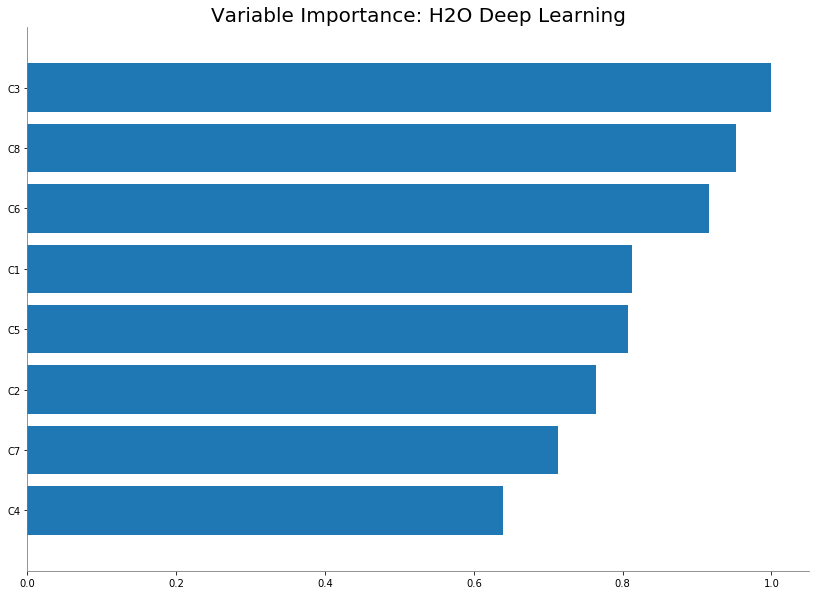

In [88]:
m.varimp_plot()

#### Partial Dependency Plot 

In [89]:
from sklearn.ensemble.partial_dependence import partial_dependence, plot_partial_dependence

/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [93]:
#my_model = GradientBoostingRegressor()
# fit the model as usual
#my_model.fit(X, y)
# Here we make the plot
#my_plots = plot_partial_dependence(m,       
                                   features=[0, 2], # column numbers of plots we want to show
                                   X=X,            # raw predictors data.
                                   feature_names=['C1', 'C2', 'C3','C4','C5','C6','C7','C8','C9'], # labels on graphs
                                   grid_resolution = 10) # number of values to plot on x axis

ValueError: gbrt has to be an instance of BaseGradientBoosting

In [98]:
gain = m.gains_lift()

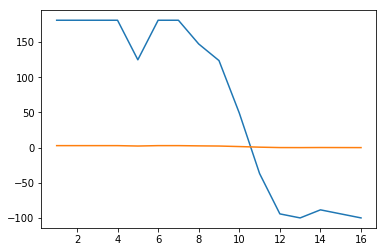

In [100]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(gain['group'],gain['gain'])
plt.plot(gain['group'],gain['lift'])